<a href="https://colab.research.google.com/github/kaiwangx/Medical-Image-Analysis/blob/master/crowd_voting/load_and_vote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade mxnet-cu101 gluoncv

     |███████████████████████████████▌| 834.1MB 1.3MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x65f64000 @  0x7f9f856b9615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 19kB/s 
     |████████████████████████████████| 819kB 22.8MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/DataSet14_20200429/raw_patient_based

/content/drive/My Drive/DataSet14_20200429/raw_patient_based


# Validation



In [4]:
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import numpy as np
import random
c = np.array(['bleeding_site'])
import csv
def getBbox(dirName):
    bboxes = []
    with open(dirName, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0
        for row in csv_reader:
            bboxes.append([int(row["BX"]), int(row["BY"]), int(row["BX"]) + 
                           int(row["Width"]), int(row["BY"]) + int(row["Height"])])
    return bboxes

In [5]:
import cv2
def validate_single(net, im_fname, first_n_prediction, iou_threshold):
    im = cv2.imread(im_fname)
    x, img = data.transforms.presets.yolo.load_test(im_fname, short=im.shape[0])
    class_IDs, scores, predicted_bounding_boxs = net(x)
    ground_truth_boxes = np.array(getBbox(im_fname.replace('.tif', '.csv')))
    # all_ground_truth_boxes in form (xmin, ymin, xmax, ymax)
    num_correct = [0] * len(iou_threshold)
    max_iou = 0
    for ground_truth_box in ground_truth_boxes:
        for box in predicted_bounding_boxs[0][:first_n_prediction]:
            box = box.asnumpy()
            xmin = max(box[0], ground_truth_box[0])
            ymin = max(box[1], ground_truth_box[1])
            xmax = min(box[2], ground_truth_box[2])
            ymax = min(box[3], ground_truth_box[3])
            inter_area = max(0, xmax - xmin + 1) * max(0, ymax - ymin + 1)
            ground_truth_box_area = (ground_truth_box[2] - ground_truth_box[0] + 1) * (ground_truth_box[3] - ground_truth_box[1] + 1)
            box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
            iou = inter_area / float(ground_truth_box_area + box_area - inter_area)
            max_iou = max(iou, max_iou)
        # print(max_iou)
        for i in range(len(iou_threshold)):
            if max_iou > iou_threshold[i]:
                num_correct[i] = 1
    return num_correct, max_iou

In [6]:
# files_path = "testfile_name.txt"
# iou_threshold: array of ious
def validate_all(net, files_path, first_n_prediction, iou_threshold):
    print("iou", iou_threshold)
    files = np.loadtxt(files_path, dtype=np.str, delimiter='/n')
    num_of_files = 0
    num_correct = [0] * len(iou_threshold)
    for file in files:
        print(file)
        single_result, iou = validate_single(net, file, first_n_prediction, iou_threshold)
        print(iou)
        for i in range(len(iou_threshold)):
            num_correct[i] += single_result[i]
        num_of_files += 1
    for i in range(len(iou_threshold)):
        print(iou_threshold[i], num_correct[i] / num_of_files)
    return num_correct, num_of_files

In [12]:
model_name = 'yolo3_darknet53_custom'
c = np.array(['bleeding_site'])
net = model_zoo.get_model(model_name, pretrained=False, classes=c)
param_name = 'Models/yolo3.params'
net.load_parameters(param_name)
first_n_prediction = 3
iou_threshold = [0.0001, 0.1, 0.2]
num_correct, num_of_files = validate_all(net, "valfile_name.txt", first_n_prediction, iou_threshold)

iou [0.0001, 0.1, 0.2]
Training/validation/Patient 75/75_23.tif
0.6054102605420649
Training/validation/Patient 75/75_25.tif
0.6207338240056541
Training/validation/Patient 75/75_27.tif
0.5552751397110481
Training/validation/Patient 75/75_29.tif
0.7254424280358063
Training/validation/Patient 75/75_31.tif
0.7884376750385619
Training/validation/Patient 75/75_33.tif
0.8120189531575019
Training/validation/Patient 75/75_35.tif
0.743992511671953
Training/validation/Patient 75/75_37.tif
0.7504307680401698
Training/validation/Patient 75/75_39.tif
0.6885504974828274
Training/validation/Patient 75/75_41.tif
0.642313180015718
Training/validation/Patient 75/75_43.tif
0.7258038308999057
Training/validation/Patient 75/75_45.tif
0.7320636171059297
Training/validation/Patient 75/75_47.tif
0.7875983429399785
Training/validation/Patient 75/75_49.tif
0.5715471340158957
Training/validation/Patient 75/75_51.tif
0.6226494522877789
Training/validation/Patient 75/75_53.tif
0.5861563353908786
Training/validation

In [ ]:
model_names = 'faster_rcnn_resnet50_v1b_custom'
model_params = 'Models/faster_rcnn2.params'
frcnn_net = model_zoo.get_model(model_names, classes=c, pretrained=False, transfer='voc')# 'faster_rcnn_resnet50_v1b_custom'
frcnn_net.load_parameters(model_params) #"faster_rcnn_resnet50_v1b_custom_best.params"
first_n_prediction = 3
iou_threshold = [0, 0.1, 0.2]
num_correct, num_of_files = validate_all(net, "testfile_name.txt", first_n_prediction, iou_threshold)

121888KB [00:02, 44963.14KB/s]                            


iou [0, 0.1, 0.2]
Testing/Bleeding/Patient 1002/1002_21_34.tif
0.0
Testing/Bleeding/Patient 1002/1002_23_34.tif
0.0
Testing/Bleeding/Patient 1002/1002_25_34.tif
0.0
Testing/Bleeding/Patient 1002/1002_27_34.tif
0.0
Testing/Bleeding/Patient 1002/1002_29_34.tif
0.0
Testing/Bleeding/Patient 1002/1002_31_34.tif
0.0
Testing/Bleeding/Patient 1003/1003_11_32.tif
0.0
Testing/Bleeding/Patient 1003/1003_15_32.tif
0.40674785218407333
Testing/Bleeding/Patient 1003/1003_19_32.tif
0.0
Testing/Bleeding/Patient 1003/1003_21_32.tif
0.1444919065643718
Testing/Bleeding/Patient 1003/1003_25_32.tif
0.29780897050896843
Testing/Bleeding/Patient 1003/1003_27_32.tif
0.21580842261160185
Testing/Bleeding/Patient 1003/1003_29_32.tif
0.19939611147412667
Testing/Bleeding/Patient 1003/1003_31_32.tif
0.008833389027163543
Testing/Bleeding/Patient 1003/1003_9_32.tif
0.0
Testing/Bleeding/Patient 1004/1004_18_51.tif
0.0
Testing/Bleeding/Patient 1004/1004_20_51.tif
0.0
Testing/Bleeding/Patient 1004/1004_22_51.tif
0.0
Testi

In [ ]:
# model_name = 'ssd_512_mobilenet1.0_custom'
model_name = 'yolo3_darknet53_custom'
# param_name = cur_version
param_name = 'lr:1e-4-epoch:500yolo3_darknet53_custom_0440_0.6042.params'
net = model_zoo.get_model(model_name, pretrained=False, classes=c)
net.load_parameters(param_name)
first_n_prediction = 3
num_correct_file, num_of_files, num_correct_box_all, num_of_boxes_all = validate_all(net, "testfile_name.txt", first_n_prediction, 0)
num_correct_file, num_of_files, num_correct_box_all, num_of_boxes_all = validate_all(net, "testfile_name.txt", first_n_prediction, 0.1)
num_correct_file, num_of_files, num_correct_box_all, num_of_boxes_all = validate_all(net, "testfile_name.txt", first_n_prediction, 0.2)

current iou =  0
0.5942857142857143
current iou =  0.1
0.5257142857142857
current iou =  0.2
0.46285714285714286


In [ ]:
# model_name = 'ssd_512_mobilenet1.0_custom'
model_name = 'yolo3_darknet53_custom'
# param_name = cur_version
param_name = 'lr:1e-4-epoch:500yolo3_darknet53_custom_best.params'
net = model_zoo.get_model(model_name, pretrained=False, classes=c)
net.load_parameters(param_name)

In [ ]:
first_n_prediction = 3
num_correct_file, num_of_files, num_correct_box_all, num_of_boxes_all = validate_all(net, "testfile_name.txt", first_n_prediction, 0)
num_correct_file, num_of_files, num_correct_box_all, num_of_boxes_all = validate_all(net, "testfile_name.txt", first_n_prediction, 0.1)
num_correct_file, num_of_files, num_correct_box_all, num_of_boxes_all = validate_all(net, "testfile_name.txt", first_n_prediction, 0.2)

current iou =  0
0.5771428571428572
current iou =  0.1
0.5314285714285715
current iou =  0.2
0.46285714285714286


In [ ]:
# last time
first_n_prediction = 3
num_correct_file, num_of_files, num_correct_box_all, num_of_boxes_all = validate_all(net, "testfile_name.txt", first_n_prediction, 0)
num_correct_file, num_of_files, num_correct_box_all, num_of_boxes_all = validate_all(net, "testfile_name.txt", first_n_prediction, 0.1)
num_correct_file, num_of_files, num_correct_box_all, num_of_boxes_all = validate_all(net, "testfile_name.txt", first_n_prediction, 0.2)

current iou =  0
0.5756097560975609
current iou =  0.1
0.5463414634146342
current iou =  0.2
0.4926829268292683


In [ ]:
model_names = 'faster_rcnn_resnet50_v1b_custom'
model_params = 'faster_rcnn_resnet50_v1b_custom_best.params'
frcnn_net = model_zoo.get_model(model_names, classes=c, pretrained=False, transfer='voc')# 'faster_rcnn_resnet50_v1b_custom'
frcnn_net.load_parameters(model_params) #"faster_rcnn_resnet50_v1b_custom_best.params"
first_n_prediction = 3
iou_threshold = [0, 0.1, 0.2]
num_correct, num_of_files = validate_all(frcnn_net, "testfile_name.txt", first_n_prediction, iou_threshold)

iou [0, 0.1, 0.2]
0 0.5257142857142857
0.1 0.42857142857142855
0.2 0.3657142857142857


# Generate BBox


In [ ]:
def write_line(img_path, boxes, score):
    # flatten
    xmin = boxes[0]
    ymin = boxes[1]
    xmax = boxes[2]
    ymax = boxes[3]
    str_box = [str(x) for x in [ymin, xmin, ymax, xmax]]
    str_path = [img_path]
    str_score = [str(score)]
    line = ', '.join(str_path + str_box + str_score) + '\n'
    return line

In [ ]:
from gluoncv import model_zoo, data, utils
import gluoncv as gcv
from mxnet import gluon
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
import random
import cv2
# from crowd_vote import *
# get bbox for single picture
'''
  input: 
    net: net after loading param
    im_fname: file name of single picture
    first_n_prediction: num of bbox from prediction
    fw = filewriter

  output: write in format (file_name, ymin, xmin, ymax, xmax)
'''
def write_bbox_single(net, im_fname, first_n_prediction, fw):
    # files = np.loadtxt(files_path, dtype=np.str, delimiter='/n')
    # for im_fname in files:
    im = cv2.imread(im_fname)
    x, img = data.transforms.presets.yolo.load_test(im_fname, short=im.shape[0])
    class_IDs, scores, predicted_bounding_boxs = net(x)
    first_n_boxes = predicted_bounding_boxs[0][:first_n_prediction]
    first_n_scores = scores[0][:first_n_prediction]
    for index in range(first_n_prediction):
        box = first_n_boxes[index]
        box = box.asnumpy()
        score = first_n_scores[index].asnumpy()
        if score < 0:
          continue
        # line = write_line(im_fname, box, first_n_scores[index])
        line = write_line(im_fname, box, score[0])
        print(line)
        fw.write(line)

In [ ]:
# model_names = [frcnn_name, yolo_name, ssd_name]
# model_params = [frcnn_param, yolo_param, ssd_param]
'''
  input:
    test_image_names: a .txt file contains all file_path to testing images
    model_names: [frcnn_name, yolo_name, ssd_name]
    model_params: [frcnn_param, yolo_param, ssd_param]
    first_n_bboxes: num of bbox from prediction

  output:
    for each image in test_image_names, write to all_bbox.txt 
'''
def generate_bbox(test_image_names, model_names, model_params, output_name, first_n_bboxes=1):
    c = np.array(['bleeding_site'])

    # # Create Faster-RCNN network and load parameters
    # frcnn_name, frcnn_param = model_names[0], model_params[0]
    # frcnn_net = model_zoo.get_model(frcnn_name, classes=c, pretrained=False, transfer='voc')# 'faster_rcnn_resnet50_v1b_custom'
    # frcnn_net.load_parameters(frcnn_param) #"faster_rcnn_resnet50_v1b_custom_best.params"

    # Create Yolo network and load parameters
    yolo_name, yolo_param = model_names[1], model_params[1]
    yolo_net = model_zoo.get_model(yolo_name, pretrained=False, classes=c)
    yolo_net.load_parameters(yolo_param)

    # Create SSD network and load parameters
    # ssd_name, ssd_param = model_names[2], model_params[2]
    # ssd_net = gcv.model_zoo.get_model(ssd_name, pretrained_base=False, norm_layer=gluon.nn.BatchNorm, classes = np.array(['bleeding_site']))
    # ssd_net.load_parameters(ssd_param)

    # Load testing images from test_image_names
    files = np.loadtxt(test_image_names, dtype=np.str, delimiter='/n')

    # get all bbox
    bboxs = [] # [frcnn_bboxs, yolo_bboxs, ssd_bboxs]
    score = []
    with open(output_name, 'w') as fw:
        for im_fname in files:
            # write_bbox_single(frcnn_net, im_fname, first_n_bboxes, fw)
            write_bbox_single(yolo_net, im_fname, first_n_bboxes, fw)
            # write_bbox_single(ssd_net, im_fname, first_n_bboxes, fw)

In [ ]:
model_names = ['faster_rcnn_resnet50_v1b_custom', 'yolo3_darknet53_custom', 'ssd_300_vgg16_atrous_custom']
model_params = ['Models/faster_rcnn2.params', 'Models/yolo3.params', 'Models/ssd.params']
generate_bbox('testfile_name.txt', model_names, model_params, 'all_bbox_n=3_yolo&frcnn.txt', 3)

121888KB [00:02, 59319.38KB/s]                            


93077KB [00:01, 61633.25KB/s]                           


Testing/Bleeding/Patient 1002/1002_21_34.tif, 585.4865, 534.027, 611.89496, 557.1433, 0.7407963

Testing/Bleeding/Patient 1002/1002_21_34.tif, 298.6519, 406.9441, 389.17532, 475.55957, 0.6934871

Testing/Bleeding/Patient 1002/1002_21_34.tif, 142.98544, 281.6961, 163.40582, 299.32916, 0.14762335

Testing/Bleeding/Patient 1002/1002_21_34.tif, 316.9182, 402.79715, 374.26752, 472.2903, 0.3345044

Testing/Bleeding/Patient 1002/1002_21_34.tif, 765.3449, 364.11008, 794.42926, 395.90433, 0.057451226

Testing/Bleeding/Patient 1002/1002_21_34.tif, 598.5291, 682.5542, 706.41864, 811.78845, 0.029242855

Testing/Bleeding/Patient 1002/1002_23_34.tif, 588.7404, 533.69336, 612.15375, 554.5488, 0.66110855

Testing/Bleeding/Patient 1002/1002_23_34.tif, 142.60374, 281.29712, 163.4807, 298.11145, 0.35199687

Testing/Bleeding/Patient 1002/1002_23_34.tif, 80.57137, 331.3208, 121.04452, 382.62903, 0.2429854

Testing/Bleeding/Patient 1002/1002_23_34.tif, 459.88577, 288.7729, 487.8823, 315.57812, 0.65069425

T

In [ ]:
model_names = ['faster_rcnn_resnet50_v1b_custom', 'yolo3_darknet53_custom', 'ssd_300_vgg16_atrous_custom']
model_params = ['Models/faster_rcnn2.params', 'Models/yolo3.params', 'Models/ssd.params']
generate_bbox('testfile_name.txt', model_names, model_params, 'all_bbox_n=1_yolo', 1)

Testing/Bleeding/Patient 1002/1002_21_34.tif, 316.9182, 402.79715, 374.26752, 472.2903, 0.3345044

Testing/Bleeding/Patient 1002/1002_23_34.tif, 459.88577, 288.7729, 487.8823, 315.57812, 0.65069425

Testing/Bleeding/Patient 1002/1002_25_34.tif, 596.1199, 689.4851, 706.1122, 805.4293, 0.032132205

Testing/Bleeding/Patient 1002/1002_27_34.tif, 755.814, 572.46606, 795.6192, 651.2699, 0.44637194

Testing/Bleeding/Patient 1002/1002_29_34.tif, 754.08203, 555.3947, 797.53784, 648.957, 0.22355223

Testing/Bleeding/Patient 1002/1002_31_34.tif, 755.57294, 564.7796, 794.81647, 663.54083, 0.06726409

Testing/Bleeding/Patient 1003/1003_15_32.tif, 500.20126, 282.04428, 541.0975, 379.35294, 0.12167111

Testing/Bleeding/Patient 1003/1003_19_32.tif, 403.35, 287.26443, 507.5092, 369.6826, 0.03522918

Testing/Bleeding/Patient 1003/1003_21_32.tif, 402.9898, 284.15854, 506.50983, 371.76743, 0.5097552

Testing/Bleeding/Patient 1003/1003_25_32.tif, 423.0798, 228.70302, 571.9713, 429.93347, 0.09136527

Testin

In [ ]:
model_names = ['faster_rcnn_resnet50_v1b_custom', 'yolo3_darknet53_custom', 'ssd_300_vgg16_atrous_custom']
model_params = ['Models/faster_rcnn.params', 'Models/yolo3.params', 'Models/ssd.params']
generate_bbox('testfile_name.txt', model_names, model_params, 'all_bbox_n=1_test_2.txt', 3)

# Voting

In [ ]:
def generate_id(files_path):
    files = np.loadtxt(files_path, dtype=np.str, delimiter='/n')
    # Generate the list of patients to be tested by crowd voting
    patient_ids = set()
    for im_fname in files:
        patient_id = im_fname.split('/')[3].split('_')[0]
        patient_ids.add(patient_id)
    return patient_ids

In [ ]:
from crowd_vote import *
all_bbox_file = "all_bbox_n=3.txt"
patient_ids = generate_id("testfile_name.txt")

In [ ]:
print(patient_ids)

{'1012', '1005', '1006', '1017', '1004', '1019', '1010', '1016', '1026', '1014', '1011', '1002', '1024', '1028', '1009', '1021', '1027', '1025', '1003'}


In [ ]:
from crowd_vote import *
all_bbox_file = "all_bbox_n=3.txt"
patient_ids = generate_id("testfile_name.txt")

vote_result = main(all_bbox_file, patient_ids)
with open('crowd_vote_result.txt', 'w') as result_f:
    for item in vote_result:
        result_f.write("%s" % item)

IndexError: ignored

# Evaluation

In [ ]:
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import numpy as np
import random
c = np.array(['bleeding_site'])
import csv
def getBbox(dirName):
    bboxes = []
    with open(dirName, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0
        for row in csv_reader:
            bboxes.append([int(row["BX"]), int(row["BY"]), int(row["BX"]) + 
                           int(row["Width"]), int(row["BY"]) + int(row["Height"])])
    return bboxes

In [ ]:
import cv2
def show(patiend_id):
    files = np.loadtxt("testfile_name.txt", dtype=np.str, delimiter='/n')
    box = []
    scores = []
    with open("Models/crowd_vote_result.txt", 'r') as reader:
        reader = reader.read().splitlines()
        for line in reader:
            vote_result_single = line.split(",")
            if (patiend_id in vote_result_single[0]):
                box = [[float(vote_result_single[2]), float(vote_result_single[1]), 
                      float(vote_result_single[4]),float(vote_result_single[3])]]
                scores = [float(vote_result_single[5])]

    print(box)

    for i in range(len(files)):
        if (patiend_id in files[i]):
            im_fname = files[i]
            print(im_fname)
            im = cv2.imread(im_fname)
            x, img = data.transforms.presets.yolo.load_test(im_fname, short=im.shape[0])
            all_boxes = np.array(getBbox(im_fname.replace('.tif', '.csv')))
            all_ids = np.array([0])
            class_names = ['bleeding']

            # see how it looks by rendering the boxes into image
            ax = utils.viz.plot_bbox(img, all_boxes, labels=all_ids, class_names=class_names, colors={0: (0, 1, 0)})

            x, img = data.transforms.presets.yolo.load_test(im_fname, short=im.shape[0])
            all_ids = np.array([0])
            
            ax = utils.viz.plot_bbox(img, box, labels=all_ids, class_names=class_names)

            plt.show()

[[74.47969, 319.9629, 137.51291, 396.9668]]
Testing/Bleeding/Patient 1024/1024_11_38.tif


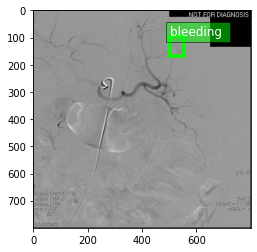

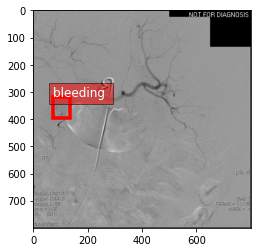

Testing/Bleeding/Patient 1024/1024_13_38.tif


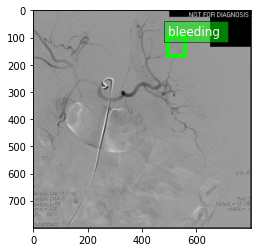

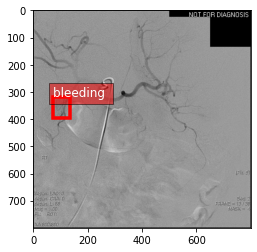

Testing/Bleeding/Patient 1024/1024_14_38.tif


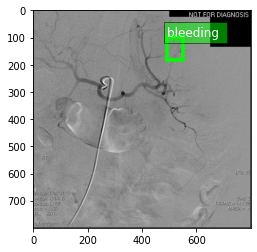

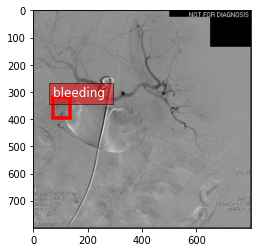

Testing/Bleeding/Patient 1024/1024_15_38.tif


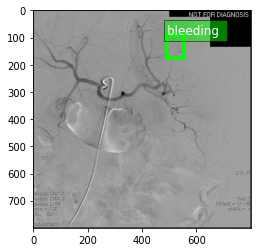

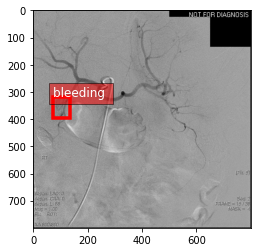

Testing/Bleeding/Patient 1024/1024_16_38.tif


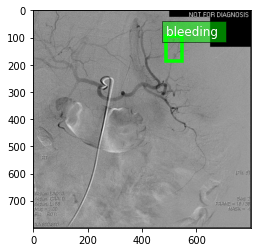

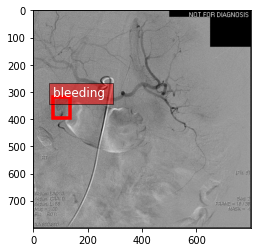

Testing/Bleeding/Patient 1024/1024_18_38.tif


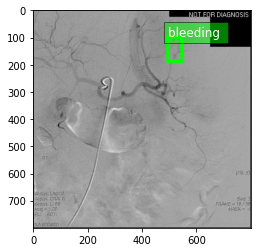

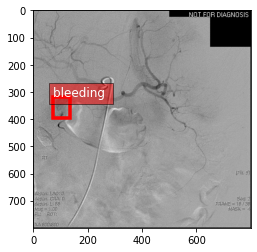

Testing/Bleeding/Patient 1024/1024_20_38.tif


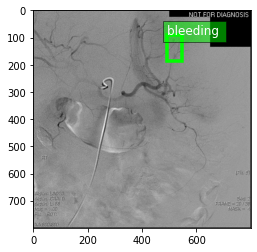

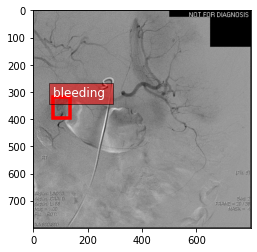

Testing/Bleeding/Patient 1024/1024_22_38.tif


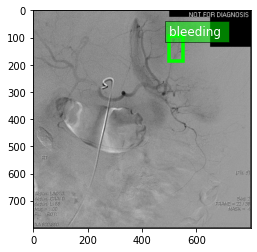

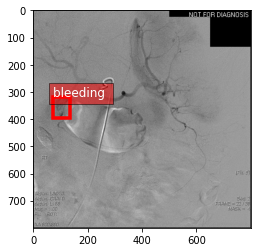

Testing/Bleeding/Patient 1024/1024_23_38.tif


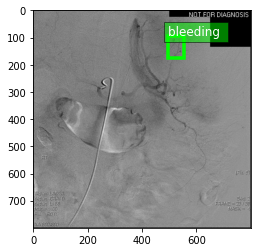

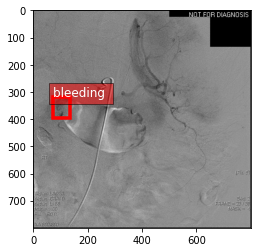

Testing/Bleeding/Patient 1024/1024_24_38.tif


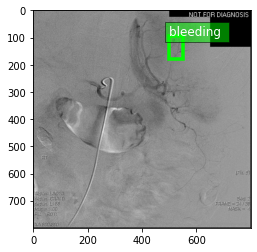

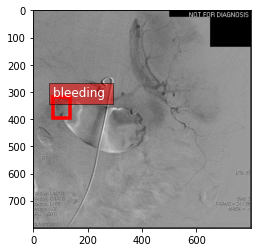

Testing/Bleeding/Patient 1024/1024_25_38.tif


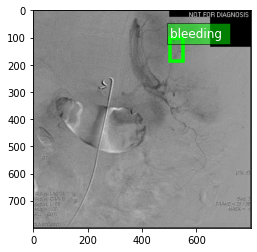

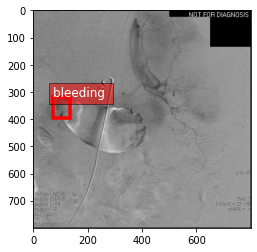

Testing/Bleeding/Patient 1024/1024_27_38.tif


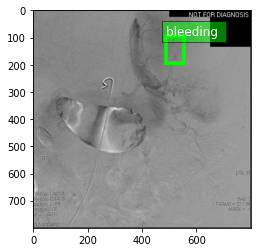

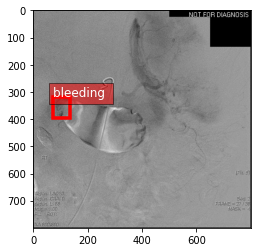

Testing/Bleeding/Patient 1024/1024_29_38.tif


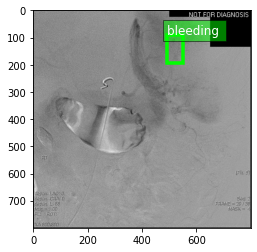

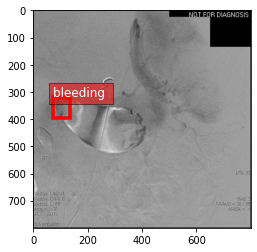

Testing/Bleeding/Patient 1024/1024_31_38.tif


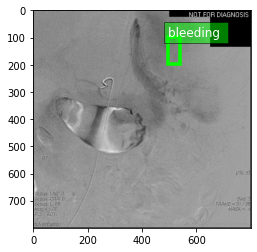

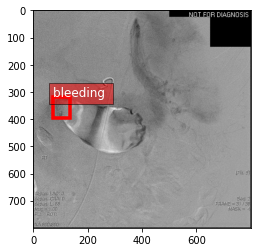

Testing/Bleeding/Patient 1024/1024_33_38.tif


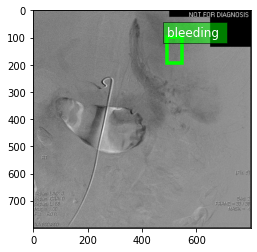

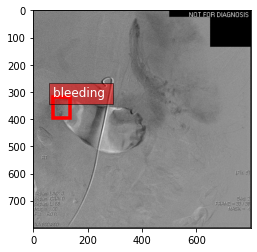

Testing/Bleeding/Patient 1024/1024_35_38.tif


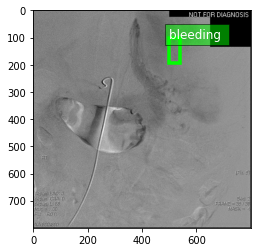

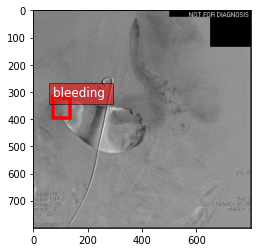

Testing/Bleeding/Patient 1024/1024_37_38.tif


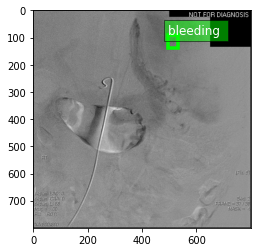

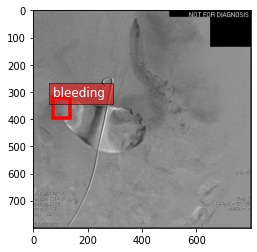

Testing/Bleeding/Patient 1024/1024_38_38.tif


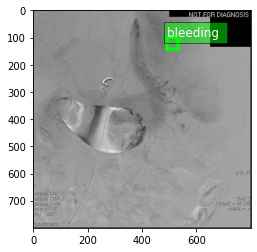

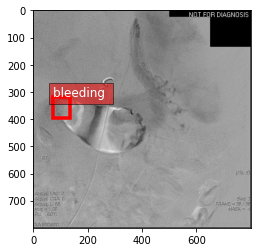

In [ ]:
show("Patient 1024")